In [1]:
import dlc_bci as bci
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
random.seed(452)
import time
from torch.autograd import Variable
from torch import nn, optim
from torch.nn import functional as F
import antoine_models

# IPython magics
%load_ext autoreload
%autoreload 2

In [2]:
torch.__version__

'0.1.12'

## Import data

In [3]:
big_data = True 
train_input, train_target = bci.load(root ="./data_bci", one_khz=big_data)
print(str(type(train_input)), train_input.size())
print(str(type(train_target)), train_target.size())
test_input, test_target = bci.load(root ="./data_bci", train = False, one_khz=False)
print(str(type(test_input)), test_input.size())
print(str(type(test_target)), test_target.size())

<class 'torch.FloatTensor'> torch.Size([316, 28, 500])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])


## visualize data

Number of training samples = 316
Number of testing samples = 100
Number of channels = 28
Number of readings per channel = 500


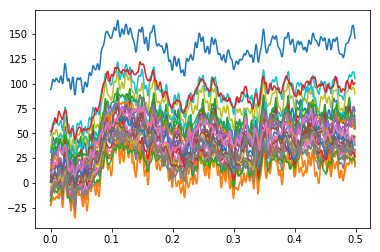

In [4]:
n_train_samples = train_target.size()[0]
print('Number of training samples = {}'.format(n_train_samples))
n_test_samples = test_target.size()[0]
print('Number of testing samples = {}'.format(n_test_samples))
n_channels = train_input.size()[1]
print('Number of channels = {}'.format(n_channels))
n_readings = train_input.size()[2]
print('Number of readings per channel = {}'.format(n_readings))

freq = 2*n_readings

tt = np.arange(0,0.5,1/freq)

for i in range(n_channels):
    plt.plot(tt,train_input[0,i,:].numpy())
    
plt.show()

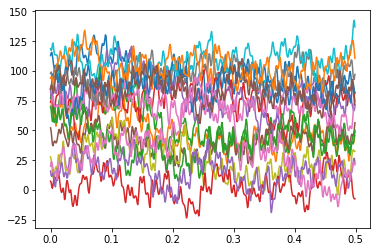

In [5]:
plt.plot(tt,train_input[10:27,8,:].numpy().transpose())
plt.show()

## Augment Data using different sampling shift

In [6]:
down_sampling = True

if(down_sampling == True):
    
    big_data_set = torch.Tensor(0,28,50)
    big_target = torch.Tensor(0)
    for i in range(10):
        shifted_data = train_input[:,:,i::10]
        big_data_set = torch.cat((big_data_set,shifted_data),0)
        big_target = torch.cat((big_target,train_target.type(torch.FloatTensor)),0)
    
train_input = big_data_set
train_target = big_target.type(torch.LongTensor)
print(train_input.size())
print(big_target.size())



torch.Size([3160, 28, 50])
torch.Size([3160])


## Normalize augmented data

In [7]:
train_input = (train_input - torch.mean(train_input))/torch.std(train_input)
test_input = (test_input - torch.mean(test_input))/torch.std(test_input)

## Define Network

In [8]:
test_input.size()[0]

100

In [9]:
MyNet = antoine_models.MyNet

## Train

In [10]:
def Validation(Y_pred, Y_true):
    return BCE(Y_true,Y_pred)

def N_true(Y_pred, Y_true):
    return torch.sum(torch.round(Y_pred).squeeze()==Y_true.float()).type(torch.FloatTensor)/Y_true.size()[0]
     
def BCE(Y_true,Y_pred):
    
    l = Variable(torch.Tensor(len(Y_true)))
    for i in range(len(Y_true)):
        if(Y_true[i]==1).data.numpy():
            l[i] = - Y_pred[i].log()
        else:
            l[i] = - (1-Y_pred[i]).log() 
        
    return torch.mean(l)

In [11]:
big_data = False
net = MyNet(big_data)
#optimizer = optim.Adam(net.parameters(), lr=0.00005)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.4)

batch_size = 15
n_max_epochs = 100
n_validation_samples = 160

train_err = []
val_err = []
val_truth = []
train_truth = []

#Prepare validation data
#print(len(train_input))
val_idx = random.sample(range(n_train_samples), int(n_validation_samples/10)) # pick 16 high resolution samples
val_list_idx = []
for k in range(10):
    for i in range(len(val_idx)):
        val_list_idx.append(val_idx[i]+316*k) #generate validation set from same 16 High resolution samples
train_idx = np.delete(np.arange(len(train_input)),val_list_idx)
#print(len(train_idx))
val_X = Variable(torch.unsqueeze(train_input[torch.LongTensor(val_list_idx)],1),requires_grad=True)
#print(len(val_X))
val_Y = Variable((train_target[torch.LongTensor(val_list_idx)]))

#Prepare training data
train_X = Variable(torch.unsqueeze(train_input[torch.LongTensor(train_idx)],1))
train_Y = Variable(train_target[torch.LongTensor(train_idx)])

for epoch in range(n_max_epochs):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    net.train()
    
    train_loss = 0.0
    epoch_true = 0.0
    #print(len(train_X))
    
    for b in range(0, len(train_X), batch_size):   #Train batch by batch
    
        output = net(train_X.narrow(0, b, batch_size))
        loss = BCE(train_Y.narrow(0, b, batch_size),output.squeeze())
        #print(loss)
        net.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step(loss)
        train_loss = (train_loss + loss.data)/2
        batch_true = N_true(output, train_Y.narrow(0, b, batch_size))
        epoch_true = (epoch_true + batch_true)
        
    net.eval()  
    
    
    val_pred = net(val_X)
    train_err.append(train_loss) #add train loss
    val_err.append(Validation(val_pred,val_Y).data) #add validation loss
    val_truth.append(N_true(val_pred,val_Y)) #add validation accuracy
    print("classification accuracy on validation set: {}".format(val_truth[epoch].data.numpy()))
    train_truth.append(epoch_true/(len(train_input)/batch_size)) #add train accuracy
    print("classification accuracy on training set: {}".format(train_truth[epoch].data.numpy()))
    
    test_pred = net(Variable(torch.unsqueeze(test_input,1)))
#print("Binary Cross Entropy loss for test set: {}".format(BCE(Variable(test_target),test_pred)))
    print("classification accuracy on test set: {}%".format((N_true(net(Variable(torch.unsqueeze(test_input,1))),Variable(test_target)))*100))

    if(abs(train_loss-val_err[epoch])>0.3): 
        '''
        Early Stopping condition if error difference between train and validation too big.
        Train error reduces & Validation error increases -> overfitting'''
        #break
    
plt.plot(range(epoch+1),val_err,range(epoch+1),train_err)
plt.legend(['validation error', 'training error'])
plt.show()




Epoch  0


AttributeError: module 'torch.nn.functional' has no attribute 'dropout2d'

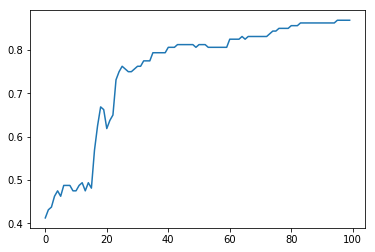

In [12]:
plt.plot(val_truth)
plt.show()

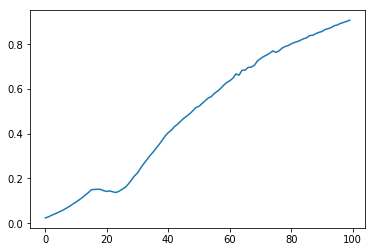

In [13]:
plt.plot(abs(np.asarray(train_err)-np.asarray(val_err)))
plt.show()